In [4]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from utils import explain

#### Create Dataframes

In [9]:
files = sorted(['data/' + _ for _ in os.listdir('data/') if '.txt' not in _])

['data/bus_char_df.csv', 'data/bus_own_df.csv', 'data/bus_tech_df.csv', 'data/comp_sum_df.csv', 'data/slbo.csv']


In [10]:
bus_char_df = pd.read_csv(files[0])
bus_own_df = pd.read_csv(files[1])
bus_tech_df = pd.read_csv(files[2])
comp_sum_df = pd.read_csv(files[3])
slbo = pd.read_csv(files[4])


In [14]:
def jeds_first_plot(comp_sum_df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    targ1 = 23
    targ2 = 52
    targ1,targ2 = str(targ1), str(targ2)

    gender_by_state_cs = comp_sum_df[
        (comp_sum_df['industry_code'].isin([targ1, targ2]))
        ].groupby(by = ['name','industry','gender']
                 )[['gender']].agg('count').rename(columns = {'gender': 'gender_count'}).reset_index()

    gender_by_state_cs.sort_values(by = ['name', 'industry', 'gender'], inplace = True)
    gs = gender_by_state_cs

    print('NOTE: Ratios are for each set of observations and not industry specific.')
    print('Building Plots... Please Wait...')
    fig, axs = plt.subplots(51,1, figsize=(15,200), sharex = False)
    fig.suptitle('Ownership Gender in a Subset of Industries by State', fontsize = 30)
    colors = {'Female':'#FD6320','Male':'#9567FE', 'Equally male/female': '#919584'}

    states = sorted(comp_sum_df.name.unique().tolist())
    for i, state in enumerate(states):
        axs[i].set_title(state, fontsize = 20)

        subset = gs[
                (gs['name'] == state) &
                (gs['gender'] != 'Total')
            ] 
        industries = sorted(subset.industry.unique().tolist())
        sns.barplot(data = subset, x = 'industry', y = 'gender_count', 
                    ax = axs[i], hue = 'gender', 
                    palette = colors, 
                    edgecolor = 'black')

        axs[i].set_ylabel('')
        axs[i].set_xlabel('')

        font = {'color': 'w',
                'weight': 'bold',
                'size': 14,
               }
        if i % 3 == 0:
            axs[i].text(-0.36,0.65, "Equal Gender\nOwnership", fontdict = font)
            axs[i].text(-0.05,0.65, "Female", fontdict = font)
            axs[i].text(0.23,0.65, "Male", fontdict = font)

        axs[i].get_legend().remove()
        axs[i].tick_params(left = False)
        axs[i].set_yticklabels('')

        gender_count = subset['gender_count'].sum()
        for c in axs[i].containers:
            labels = [
                f'{(h/gender_count)*100:0.1f}%' if (
                    h := v.get_height()) > 0 else "" for v in c
            ]

            axs[i].bar_label(c,labels=labels,label_type = 'edge',fontsize = 17,color= 'black')
        axs[i].tick_params(axis = 'x', labelsize = 18)

    plt.tight_layout()
    plt.subplots_adjust(hspace = 1,top = 0.97)
    sns.despine(left = True, bottom = True)
    print('Done... Displaying Plots...')

    #plt.savefig('gender_ownership_state.pdf')
#jeds_first_plot(comp_sum_df)  ## Uncomment to run the plot

In [37]:
reason_owned = bus_own_df[
    (bus_own_df['qdesc_label'] == 'REASONOWN') &
    (~bus_own_df['industry'].str.contains('Total')) &
    (~bus_own_df['gender'].str.contains('All')) &
    (bus_own_df['ownchar_label'].str.contains(':'))]

reason_owned[['reason','importance']] = reason_owned.apply(
    lambda row: row['ownchar_label'].split(":"), axis = 1, result_type = 'expand'
)

reason_owned = reason_owned[['industry','gender','reason','importance','ownpdemp']]

grouped_reason = reason_owned.groupby(
    by = ['industry','reason','importance'])[['ownpdemp']].agg(
    responses = ('ownpdemp', 'sum')
)

grouped_reason['ratio'] = 100 * (grouped_reason['responses'] / grouped_reason.groupby(level = [0,1])['responses'].transform('sum'))
grouped_reason['ratio'] = grouped_reason['ratio'].round(2)
grouped_reason.reset_index(inplace = True)

accom_subset = grouped_reason[(grouped_reason['industry'].str.contains('inanc'))]
accom_subset.sort_values(by = ['ratio'], inplace = True)
picked_industry = accom_subset['industry'].unique().tolist()[0]

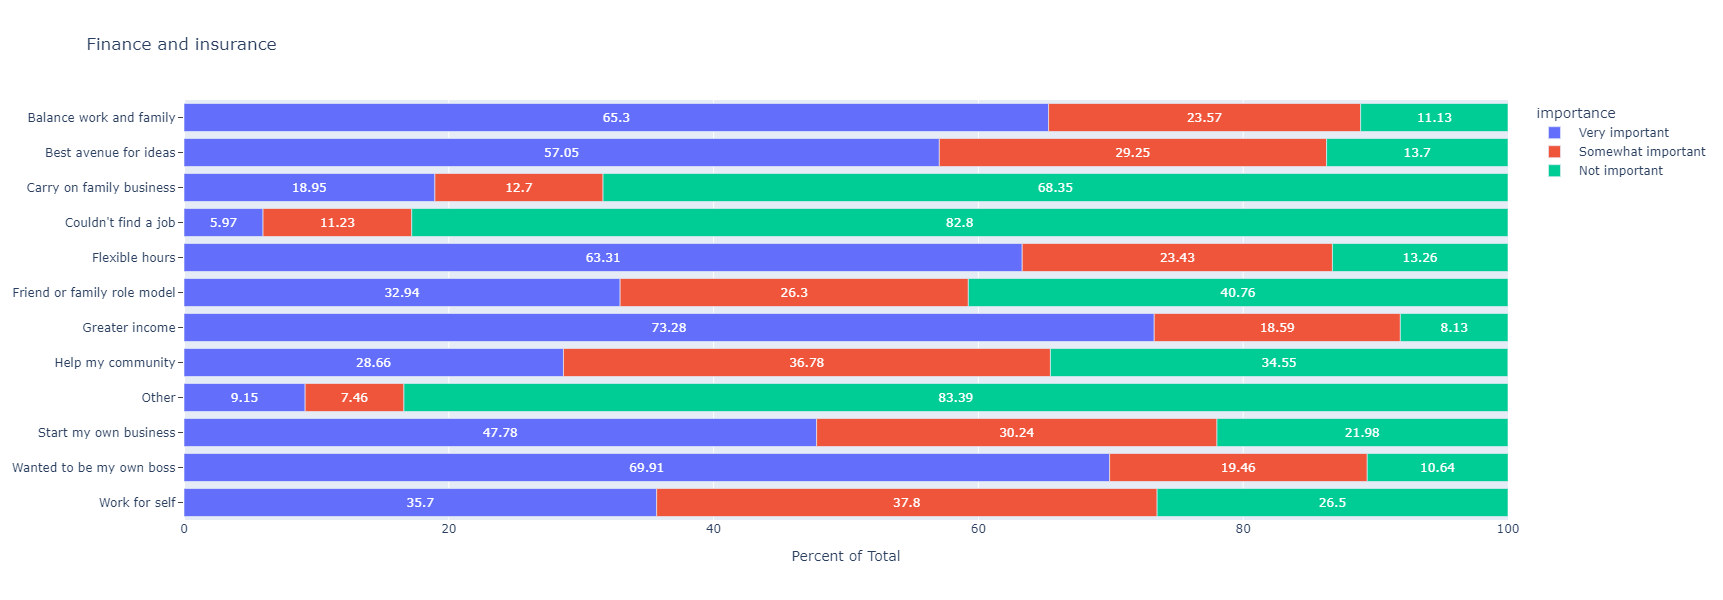

In [38]:
fig = px.bar(accom_subset, x = 'ratio', y = 'reason', color = 'importance',
            width = 1000, height = 600, orientation = 'h', title = picked_industry,
             hover_data = ['responses','ratio'], text = 'ratio'
            )
fig.update_layout(yaxis_title = None)

fig.update_traces(textposition = 'inside', insidetextanchor = 'middle', textfont = {'color': 'white'})
fig.update_yaxes(categoryorder = 'category descending', ticks = 'outside')
fig.update_layout(xaxis_title = "Percent of Total", uniformtext_minsize = 12,
                 uniformtext_mode = 'hide')

fig.update_xaxes(range = [0,100])

fig.show()